# Bitcoin Price Prediction - Logistic Regression Baseline Model
## Özellikler:

In [1]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


## 1. Veri Toplama - Son 2 Yılın Bitcoin Verileri

In [2]:
# Son 2 yılın Bitcoin verilerini çekelim
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 yıl = 730 gün

print(f"Veri çekme tarih aralığı: {start_date.date()} - {end_date.date()}")

# Bitcoin verilerini yfinance ile çekelim
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start=start_date, end=end_date)

print(f"\nToplam {len(btc_data)} günlük veri çekildi")
print(f"\nVeri şekli: {btc_data.shape}")
print("\nİlk  satır:")
print(btc_data.head(10))
print("\nSon  satır:")
print(btc_data.tail(10))

Veri çekme tarih aralığı: 2023-11-26 - 2025-11-25

Toplam 730 günlük veri çekildi

Veri şekli: (730, 7)

İlk  satır:
                                   Open          High           Low  \
Date                                                                  
2023-11-26 00:00:00+00:00  37796.828125  37820.300781  37162.750000   
2023-11-27 00:00:00+00:00  37454.191406  37559.355469  36750.128906   
2023-11-28 00:00:00+00:00  37247.992188  38368.480469  36891.089844   
2023-11-29 00:00:00+00:00  37826.105469  38366.113281  37612.632812   
2023-11-30 00:00:00+00:00  37861.117188  38141.753906  37531.140625   
2023-12-01 00:00:00+00:00  37718.007812  38954.109375  37629.359375   
2023-12-02 00:00:00+00:00  38689.277344  39678.937500  38652.593750   
2023-12-03 00:00:00+00:00  39472.207031  40135.605469  39298.164062   
2023-12-04 00:00:00+00:00  39978.628906  42371.750000  39978.628906   
2023-12-05 00:00:00+00:00  41986.265625  44408.664062  41421.148438   

                              

## 2. Özellik Mühendisliği (Feature Engineering)

In [3]:
# Özellik mühendisliğini tekrar kullanılabilir hale getirelim

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def engineer_features(price_df: pd.DataFrame, drop_na: bool = True) -> pd.DataFrame:
    """
    Fiyat verilerinden teknik indikatörleri hesaplar.
    
    Parameters:
    -----------
    price_df : pd.DataFrame
        OHLCV verisi içeren DataFrame
    drop_na : bool, default=True
        NaN değerleri içeren satırları silip silmeyeceğimizi belirtir.
        İlk veri işleme için True, simülasyon için False kullanılmalı.
    """
    df_local = price_df.copy()
    df_local['Price'] = df_local['Close']

    # . Moving Averages
    df_local['MA_7'] = df_local['Close'].rolling(window=7).mean()
    df_local['MA_14'] = df_local['Close'].rolling(window=14).mean()
    df_local['MA_30'] = df_local['Close'].rolling(window=30).mean()
    df_local['MA_50'] = df_local['Close'].rolling(window=50).mean()

    # . RSI (Relative Strength Index)
    df_local['RSI'] = calculate_rsi(df_local['Close'])

    # . MACD
    ema_12 = df_local['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df_local['Close'].ewm(span=26, adjust=False).mean()
    df_local['MACD'] = ema_12 - ema_26
    df_local['MACD_Signal'] = df_local['MACD'].ewm(span=9, adjust=False).mean()
    df_local['MACD_Hist'] = df_local['MACD'] - df_local['MACD_Signal']

    # . Bollinger Bands
    df_local['BB_Middle'] = df_local['Close'].rolling(window=20).mean()
    bb_std = df_local['Close'].rolling(window=20).std()
    df_local['BB_Upper'] = df_local['BB_Middle'] + (bb_std * 2)
    df_local['BB_Lower'] = df_local['BB_Middle'] - (bb_std * 2)
    df_local['BB_Width'] = df_local['BB_Upper'] - df_local['BB_Lower']
    df_local['BB_Position'] = (df_local['Close'] - df_local['BB_Lower']) / (df_local['BB_Upper'] - df_local['BB_Lower'])

    # . Price Change Features
    df_local['Price_Change'] = df_local['Close'].pct_change()
    df_local['Price_Change_7'] = df_local['Close'].pct_change(periods=7)
    df_local['Price_Change_14'] = df_local['Close'].pct_change(periods=14)
    df_local['Price_Change_30'] = df_local['Close'].pct_change(periods=30)

    # 6. Volatility
    df_local['Volatility'] = df_local['Price_Change'].rolling(window=7).std()
    df_local['Volatility_30'] = df_local['Price_Change'].rolling(window=30).std()

    # 7. High-Low Features
    df_local['HL_Ratio'] = df_local['High'] / df_local['Low']
    df_local['OC_Ratio'] = df_local['Open'] / df_local['Close']

    # 8. Volume Features
    df_local['Volume_MA'] = df_local['Volume'].rolling(window=20).mean()
    df_local['Volume_Ratio'] = df_local['Volume'] / df_local['Volume_MA']

    # 9. Lag Features (GENİŞLETİLDİ)
    for lag in [1, 2, 3, 5, 7, 10, 14, 21, 30]:
        df_local[f'Close_Lag_{lag}'] = df_local['Close'].shift(lag)
        df_local[f'Volume_Lag_{lag}'] = df_local['Volume'].shift(lag)
    
    # 0. Feature Interactions (YENİ)
    df_local['RSI_x_MACD'] = df_local['RSI'] * df_local['MACD']
    df_local['MA_7_div_MA_30'] = df_local['MA_7'] / df_local['MA_30']
    df_local['MA_14_div_MA_50'] = df_local['MA_14'] / df_local['MA_50']
    df_local['Price_x_Volume'] = df_local['Close'] * df_local['Volume']
    df_local['RSI_x_Volatility'] = df_local['RSI'] * df_local['Volatility']
    
    # . Time Features (YENİ)
    df_local['DayOfWeek'] = df_local.index.dayofweek
    df_local['Month'] = df_local.index.month
    df_local['Quarter'] = df_local.index.quarter
    df_local['DayOfMonth'] = df_local.index.day
    df_local['WeekOfYear'] = df_local.index.isocalendar().week

    # dropna parametresine göre karar ver
    if drop_na:
        df_local = df_local.dropna()
    
    return df_local


df = engineer_features(btc_data)

print(f" Özellik mühendisliği tamamlandı!")
print(f" Toplam özellik sayısı: {len(df.columns)}")
print(f"\n🆕 Yeni eklenen özellikler:")
print(f"\n Tüm Özellikler ({len(df.columns)} adet):")


 Özellik mühendisliği tamamlandı!
 Toplam özellik sayısı: 59

🆕 Yeni eklenen özellikler:

 Tüm Özellikler (59 adet):


In [4]:
# Hedef değişken: Bir sonraki gün fiyat artacak mı? (1: Artış, 0: Azalış/Düşüş)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Son satırı kaldıralım çünkü target değeri yok
df = df[:-1]

print(f"Hedef değişken oluşturuldu!")
print(f"\nHedef değişken dağılımı:")
print(df['Target'].value_counts())
print(f"\nArtış oranı: {df['Target'].mean():.2%}")

Hedef değişken oluşturuldu!

Hedef değişken dağılımı:
Target
1    350
0    330
Name: count, dtype: int64

Artış oranı: 51.47%


## 4. Özellik Seçimi - Recursive Feature Elimination (RFE)

In [5]:
# Model için kullanılacak özellikleri seçelim
feature_columns = [col for col in df.columns if col not in ['Target', 'Open', 'High', 'Low', 'Close', 'Price', 'Volume']]

X = df[feature_columns].copy()
y = df['Target'].copy()

print(f"Toplam özellik sayısı: {len(feature_columns)}")
print(f"\nÖzellikler: {feature_columns}")

# Eksik değerleri kontrol edelim
print(f"\nEksik değer sayısı: {X.isnull().sum().sum()}")

Toplam özellik sayısı: 53

Özellikler: ['Dividends', 'Stock Splits', 'MA_7', 'MA_14', 'MA_30', 'MA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Price_Change', 'Price_Change_7', 'Price_Change_14', 'Price_Change_30', 'Volatility', 'Volatility_30', 'HL_Ratio', 'OC_Ratio', 'Volume_MA', 'Volume_Ratio', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Close_Lag_7', 'Volume_Lag_7', 'Close_Lag_10', 'Volume_Lag_10', 'Close_Lag_14', 'Volume_Lag_14', 'Close_Lag_21', 'Volume_Lag_21', 'Close_Lag_30', 'Volume_Lag_30', 'RSI_x_MACD', 'MA_7_div_MA_30', 'MA_14_div_MA_50', 'Price_x_Volume', 'RSI_x_Volatility', 'DayOfWeek', 'Month', 'Quarter', 'DayOfMonth', 'WeekOfYear']

Eksik değer sayısı: 0


In [6]:
# Veriyi train ve test setlerine ayıralım
# Son 30 günü test için ayırıyoruz (30 günlük tahmin için)
test_size = 30
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Veriyi normalize edelim
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame'e geri dönüştürelim
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Eğitim seti boyutu: (650, 53)
Test seti boyutu: (30, 53)


In [7]:
# RFE ile özellik seçimi
# Önce bir Logistic Regression modeli oluşturalım
lr_base = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')

# RFE ile en önemli 0 özelliği seçelim (sayıyı ihtiyaca göre ayarlayabilirsiniz)
n_features = min(20, len(feature_columns))
rfe = RFE(estimator=lr_base, n_features_to_select=n_features, step=1)
rfe.fit(X_train_scaled, y_train)

# Seçilen özellikler
selected_features = X_train_scaled.columns[rfe.support_].tolist()

print(f"Toplam özellik sayısı: {len(feature_columns)}")
print(f"RFE ile seçilen özellik sayısı: {len(selected_features)}")
print(f"\nSeçilen özellikler:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Özellik önem sıralaması
feature_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Rank')

print(f"\nÖzellik sıralaması (ilk 0):")
print(feature_ranking.head(10))


Toplam özellik sayısı: 53
RFE ile seçilen özellik sayısı: 20

Seçilen özellikler:
1. RSI
2. MACD
3. MACD_Hist
4. BB_Width
5. BB_Position
6. Price_Change
7. Price_Change_7
8. Price_Change_14
9. Volatility
10. Volume_Ratio
11. Close_Lag_3
12. Volume_Lag_3
13. Close_Lag_7
14. Close_Lag_21
15. Close_Lag_30
16. MA_7_div_MA_30
17. RSI_x_Volatility
18. DayOfWeek
19. Month
20. WeekOfYear

Özellik sıralaması (ilk 0):
            Feature  Rank  Selected
52       WeekOfYear     1      True
29      Close_Lag_3     1      True
33      Close_Lag_7     1      True
24     Volume_Ratio     1      True
39     Close_Lag_21     1      True
19       Volatility     1      True
41     Close_Lag_30     1      True
17  Price_Change_14     1      True
16   Price_Change_7     1      True
30     Volume_Lag_3     1      True


## 5. Logistic Regression Modeli Eğitimi

In [8]:
# Seçilen özelliklerle modeli eğitelim
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# Logistic Regression modeli
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', class_weight='balanced')
lr_model.fit(X_train_selected, y_train)

# Eğitim ve test tahminleri
y_train_pred = lr_model.predict(X_train_selected)
y_test_pred = lr_model.predict(X_test_selected)

# Olasılık tahminleri
y_train_proba = lr_model.predict_proba(X_train_selected)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_selected)[:, 1]

print("Model eğitimi tamamlandı!")
print(f"\nEğitim seti doğruluğu: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test seti doğruluğu: {accuracy_score(y_test, y_test_pred):.2f}")

print("\n=== Test Seti Sınıflandırma Raporu ===")
print(classification_report(y_test, y_test_pred, target_names=['Düşüş', 'Artış']))

Model eğitimi tamamlandı!

Eğitim seti doğruluğu: 0.58
Test seti doğruluğu: 0.53

=== Test Seti Sınıflandırma Raporu ===
              precision    recall  f1-score   support

       Düşüş       0.70      0.39      0.50        18
       Artış       0.45      0.75      0.56        12

    accuracy                           0.53        30
   macro avg       0.57      0.57      0.53        30
weighted avg       0.60      0.53      0.53        30



## 6. Model Performans Görselleştirme

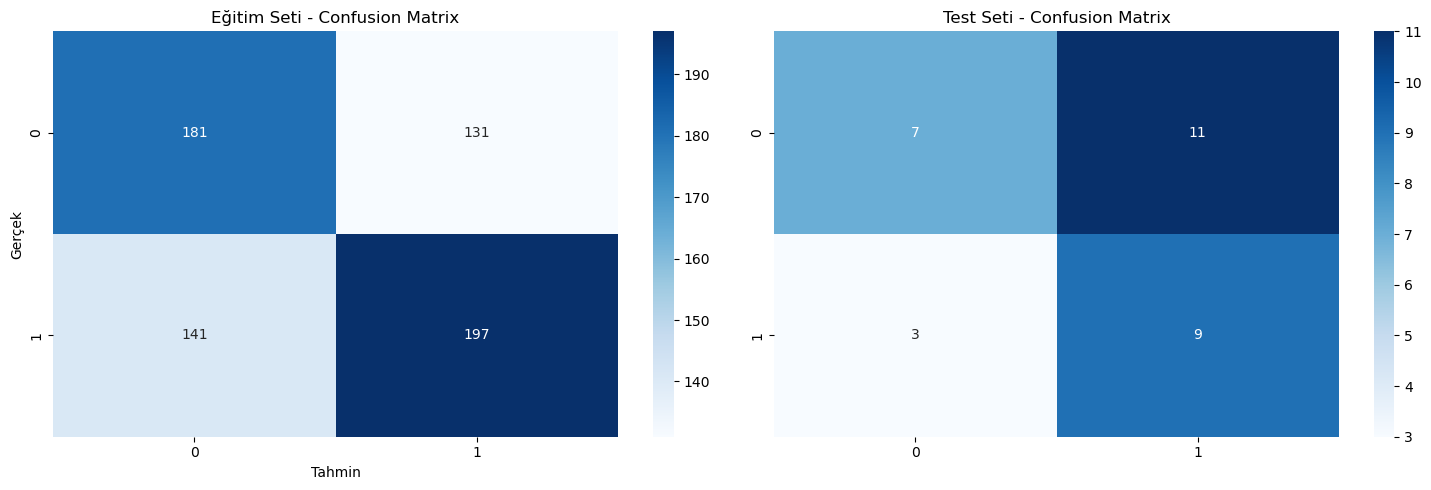

In [9]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Eğitim seti confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Eğitim Seti - Confusion Matrix')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

# Test seti confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Seti - Confusion Matrix')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

plt.tight_layout()
plt.show()

## 7. Önümüzdeki 30 Günün Tahmini

In [10]:
BASE_PRICE_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


def generate_future_base_row(price_history, engineered_history, prediction, probability):
    """
    Tahmine göre bir sonraki günün OHLCV değerlerini oluşturur.
    """
    last_date = price_history.index[-1]
    next_date = last_date + pd.Timedelta(days=1)
    
    # Son kapanış fiyatı
    last_close = price_history['Close'].iloc[-1]
    
    # 🔥 ÖNEMLİ: price_history'den hesapla (her iterasyonda güncelleniyor)
    recent_closes = price_history['Close'].tail(10)  # 30 günlük değişim için 10 fiyat gerekli
    recent_changes = recent_closes.pct_change().dropna()
    baseline_change = recent_changes.mean() if not recent_changes.empty else 0.01
    volatility = recent_changes.std() if not recent_changes.empty else 0.01

    # RASTGELE VOLATILITE: Her gün farklı olmalı!
    daily_volatility = volatility * np.random.uniform(0.5, 2.0)
    
    # Tahmine göre yönlü hareket + rastgele volatilite
    direction_bias = 0.005 if prediction == 1 else -0.005
    random_noise = np.random.normal(0, daily_volatility)
    total_change = baseline_change + direction_bias + random_noise
    
    # Olasılığa göre etki miktarını ayarla
    confidence = abs(probability - 0.5) * 2
    total_change *= (0.5 + confidence * 0.5)
    
    new_close = last_close * (1 + total_change)
    
    # OHLC değerlerini oluştur
    daily_range = new_close * (volatility * np.random.uniform(0.5, 1.5))
    new_high = new_close + daily_range * np.random.uniform(0.3, 0.7)
    new_low = new_close - daily_range * np.random.uniform(0.3, 0.7)
    new_open = new_low + (new_high - new_low) * np.random.uniform(0.2, 0.8)
    
    # Volume ayarlaması
    last_volume = price_history['Volume'].iloc[-1]
    recent_volumes = price_history['Volume'].tail(10)
    baseline_volume_change = recent_volumes.pct_change().mean()
    volume_volatility = recent_volumes.pct_change().std() if len(recent_volumes) > 1 else 0.01
    
    # Tahmin yönüne göre volume ayarlaması
    direction_factor = 1 if prediction == 1 else -1
    volume_adjustment = direction_factor * volume_volatility * 0.2  # Hafif etki
    volume_random = np.random.normal(0, volume_volatility * 0.5)
    new_volume = last_volume * (1 + baseline_volume_change + volume_adjustment + volume_random)
    
    if new_volume <= 0 or np.isnan(new_volume):
        new_volume = last_volume
    
    return next_date, {
        'Open': float(new_open),
        'High': float(new_high),
        'Low': float(new_low),
        'Close': float(new_close),
        'Volume': float(new_volume),
        'Dividends': 0.0,
        'Stock Splits': 0.0
    }


def simulate_future_path(model,
                          scaler,
                          feature_df: pd.DataFrame,
                          feature_columns: list,
                          selected_features: list,
                          n_days: int = 30):
    """Model tahminleriyle gelecek n gün için sentetik fiyat yolu oluşturur."""
    price_history = feature_df[BASE_PRICE_COLUMNS].copy()
    extended_price_history = price_history.copy()

    predictions, probabilities, predicted_closes, future_dates = [], [], [], []

    # İlk engineered history'yi oluştur (dropna ile)
    engineered_history = engineer_features(extended_price_history, drop_na=True)

    for day_num in range(n_days):
        # Son satırın özelliklerini al
        latest_features = engineered_history[feature_columns].iloc[[-1]]
        
        #  NaN KONTROLÜ
        if latest_features.isna().any().any():
            print(f"  Gün {day_num + 1}: NaN değerler tespit edildi!")
            latest_features = latest_features.fillna(method='ffill').fillna(0)
        
        # Özellikleri normalize et
        latest_scaled = scaler.transform(latest_features)
        latest_scaled = pd.DataFrame(latest_scaled, columns=feature_columns, index=latest_features.index)
        X_pred = latest_scaled[selected_features]

        # Tahmin yap
        probability = float(model.predict_proba(X_pred)[0, 1])
        prediction = 1 if probability >= 0.5 else 0

        # Yeni fiyat satırı oluştur
        next_date, new_row = generate_future_base_row(extended_price_history, engineered_history, prediction, probability)
        extended_price_history.loc[next_date] = new_row

        # Sonuçları kaydet
        predictions.append(prediction)
        probabilities.append(probability)
        predicted_closes.append(new_row['Close'])
        future_dates.append(next_date)

        #  FIX: Tüm özellikleri yeniden hesapla (drop_na=False ile)
        engineered_history = engineer_features(extended_price_history, drop_na=False)
        
        # NaN kontrolü ve doldurma
        if engineered_history.isna().any().any():
            engineered_history = engineered_history.fillna(method='ffill').fillna(0)

    future_engineered = engineered_history.loc[engineered_history.index.intersection(future_dates)]

    return {
        'predictions': predictions,
        'probabilities': probabilities,
        'predicted_closes': predicted_closes,
        'future_dates': future_dates,
        'future_engineered_features': future_engineered
    }


In [11]:
# 30 günlük tahmin için fonksiyon
def predict_next_30_days(model, scaler, df, feature_columns, selected_features, n_days=30):
    """Gelecek n gün için tahminleri ve sentetik fiyat yolunu döndürür."""
    simulation = simulate_future_path(
        model=model,
        scaler=scaler,
        feature_df=df,
        feature_columns=feature_columns,
        selected_features=selected_features,
        n_days=n_days
    )
    return simulation['predictions'], simulation['probabilities'], simulation

# Tahminleri yapalım
print("30 günlük tahmin başlatılıyor...")
future_predictions, future_probabilities, simulation_cache = predict_next_30_days(
    lr_model, scaler, df, feature_columns, selected_features, n_days=30)
future_prices = simulation_cache['predicted_closes']
future_dates = simulation_cache['future_dates']

print("30 günlük tahmin tamamlandı!")
print(f"\n{'='*80}")
print("GÜNLÜK TAHMİN SONUÇLARI")
print(f"{'='*80}")
print(f"{'-'*80}")
for i, (pred, prob, price, date) in enumerate(zip(future_predictions, future_probabilities, future_prices, future_dates), 1):
    direction = "Artış ▲" if pred == 1 else "Düşüş ▼"
    print(f"{i:<6} {str(date.date()):<12} {direction:<10} {prob:>6.1%} {'$' + f'{price:,.2f}':>}")

increase_count = sum(future_predictions)
decrease_count = len(future_predictions) - increase_count

print(f"\n{'='*80}")
print("ÖZET İSTATİSTİKLER")
print(f"{'='*80}")
print(f"Artış tahmini: {increase_count} gün ({increase_count/len(future_predictions):.2%})")
print(f"Düşüş tahmini: {decrease_count} gün ({decrease_count/len(future_predictions):.2%})")
print(f"Ortalama olasılık: {np.mean(future_probabilities):.2%}")
print(f"Olasılık std sapması: {np.std(future_probabilities):.2f}")
print(f"\nBaşlangıç fiyatı: ${df['Close'].iloc[-1]:,.2f}")
print(f"30 gün sonra tahmini fiyat: ${future_prices[-1]:,.2f}")
print(f"Beklenen toplam değişim: {((future_prices[-1] - df['Close'].iloc[-1]) / df['Close'].iloc[-1] * 100):+.1f}%")
print(f"{'='*80}")

30 günlük tahmin başlatılıyor...
30 günlük tahmin tamamlandı!

GÜNLÜK TAHMİN SONUÇLARI
--------------------------------------------------------------------------------
1      2025-11-24   Artış ▲     79.7% $85,565.73
2      2025-11-25   Artış ▲     58.6% $82,348.10
3      2025-11-26   Artış ▲     86.2% $80,187.10
4      2025-11-27   Artış ▲     90.6% $83,494.70
5      2025-11-28   Artış ▲     78.1% $86,092.95
6      2025-11-29   Artış ▲     80.2% $85,603.79
7      2025-11-30   Artış ▲     81.2% $85,928.20
8      2025-12-01   Artış ▲     82.2% $83,379.49
9      2025-12-02   Artış ▲     71.4% $84,616.44
10     2025-12-03   Düşüş ▼     37.0% $84,959.93
11     2025-12-04   Düşüş ▼     34.9% $84,223.19
12     2025-12-05   Düşüş ▼     30.2% $83,360.01
13     2025-12-06   Düşüş ▼     16.9% $82,926.74
14     2025-12-07   Düşüş ▼      8.9% $81,416.16
15     2025-12-08   Düşüş ▼      2.6% $80,171.46
16     2025-12-09   Düşüş ▼      0.3% $80,124.85
17     2025-12-10   Düşüş ▼      0.0% $80,292.22

## 8. Model Özeti ve Sonuçlar

In [12]:
print("="*60)
print(" MODEL ÖZETİ")
print("="*60)

print(f"\n PERFORMANS:")
print(f"   • Eğitim doğruluğu: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"   • Test doğruluğu: {accuracy_score(y_test, y_test_pred):.2%}")

print(f"\n 30 GÜNLÜK TAHMİN:")
print(f"   • Artış: {sum(future_predictions)} gün ({sum(future_predictions)/30:.2%})")
print(f"   • Düşüş: {30-sum(future_predictions)} gün ({(30-sum(future_predictions))/30:.2%})")

print(f"\n VERİ:")
print(f"   • Toplam: {len(feature_columns)} özellik")
print(f"   • Seçilen: {len(selected_features)} özellik (RFE)")

print("="*60)

 MODEL ÖZETİ

 PERFORMANS:
   • Eğitim doğruluğu: 58.15%
   • Test doğruluğu: 53.33%

 30 GÜNLÜK TAHMİN:
   • Artış: 9 gün (30.00%)
   • Düşüş: 21 gün (70.00%)

 VERİ:
   • Toplam: 53 özellik
   • Seçilen: 20 özellik (RFE)


## 9. Özellik Önem Analizi

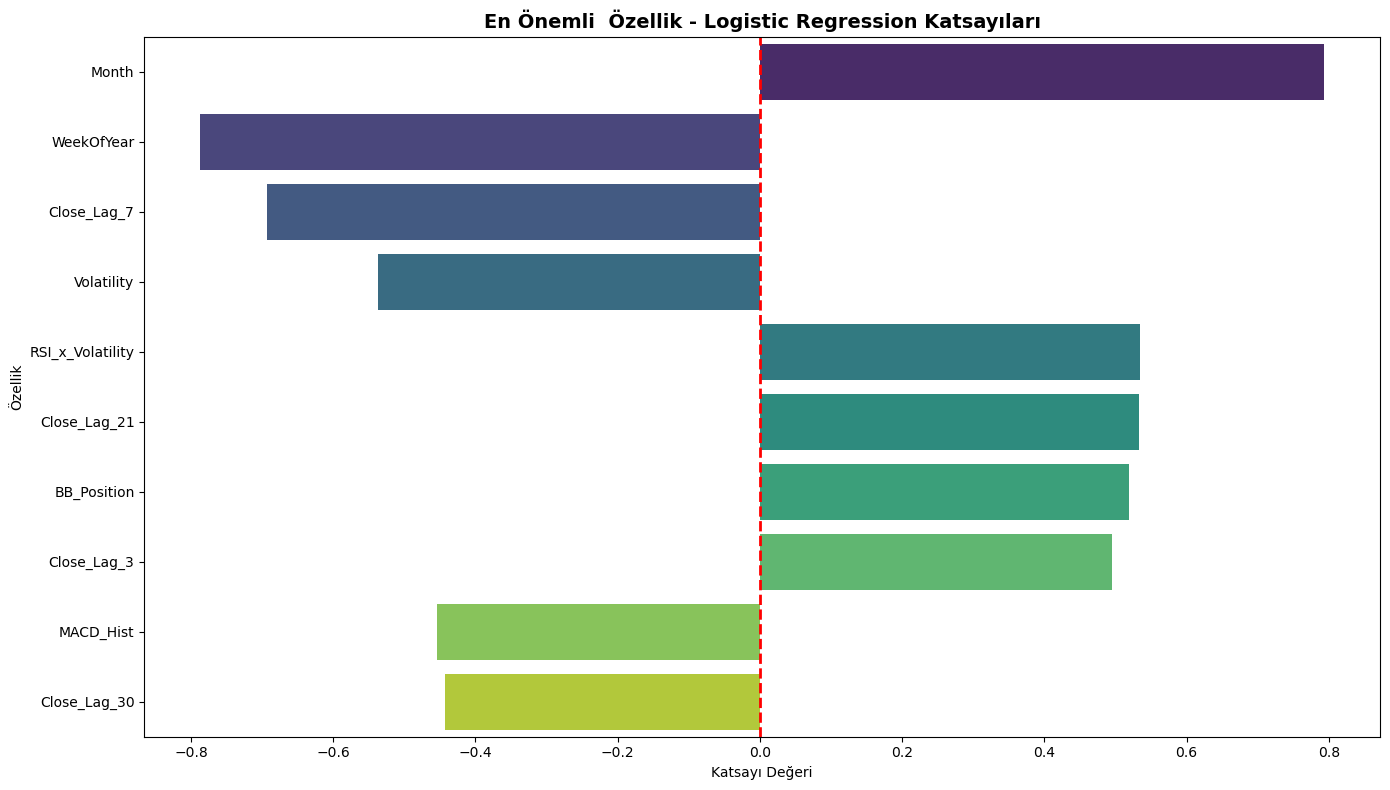

En önemli 10 özellik:


In [13]:
# Model katsayılarını alarak özellik önemini görselleştirelim
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=feature_importance.head(10), y='Feature', x='Coefficient', palette='viridis')
plt.title('En Önemli  Özellik - Logistic Regression Katsayıları', fontsize=14, fontweight='bold')
plt.xlabel('Katsayı Değeri')
plt.ylabel('Özellik')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

print("En önemli 10 özellik:")

In [14]:
## 10. Gelecek 30 Günlük Detaylı Analiz

# Fiyat senaryolarını oluştur
current_price = df['Close'].iloc[-1]
volatility = df['Price_Change'].tail(30).std()
price_scenarios = []

for day, (pred, prob, price) in enumerate(zip(future_predictions, future_probabilities, future_prices), 1):
    base_price = price
    optimistic_price = price * (1 + volatility)
    pessimistic_price = price * (1 - volatility)
    expected_change_pct = (price - current_price) / current_price * 100
    
    price_scenarios.append({
        'day': day,
        'prediction': pred,
        'probability': prob,
        'base_price': base_price,
        'optimistic_price': optimistic_price,
        'pessimistic_price': pessimistic_price,
        'expected_change_pct': expected_change_pct
    })


# Değişkenleri global scope'a aktar
future_predictions_detailed = future_predictions
future_probabilities_detailed = future_probabilities
print("\n Detaylı analiz tamamlandı!")


 Detaylı analiz tamamlandı!


In [15]:
# Analiz sonuçlarını DataFrame'e dönüştürelim
current_price = df['Close'].iloc[-1]
analysis_df = pd.DataFrame(price_scenarios)

# Kümülatif değişim hesapla (mevcut fiyata göre yüzde değişim)
analysis_df['cumulative_change_pct'] = ((analysis_df['base_price'] - current_price) / current_price * 100)

print("=" * 80)
print("GELECEK 30 GÜNLÜK DETAYLI ANALİZ RAPORU")
print("=" * 80)
print(f"\nMevcut Bitcoin Fiyatı: ${current_price:,.2f}")
print(f"Analiz Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'='*80}")
print("GÜNLÜK TAHMİN ÖZETİ")
print(f"{'='*80}")

for idx, row in analysis_df.iterrows():
    direction = "Artış" if row['prediction'] == 1 else "Düşüş"
    print(f"{int(row['day']):<6} {direction:<10} {row['probability']:.2%} {'$' + str(int(row['base_price'])):<8} {row['expected_change_pct']:>6.1f}%")

print(f"\n{'='*80}")
print("GENEL İSTATİSTİKLER")
print(f"{'='*80}")

increase_days = sum(future_predictions_detailed)
decrease_days = 30 - increase_days
avg_probability = np.mean(future_probabilities_detailed)

final_price = analysis_df['base_price'].iloc[-1]
total_change = ((final_price - current_price) / current_price) * 100

print(f"Artış tahmini: {increase_days} gün ({increase_days/30:.2%})")
print(f"Düşüş tahmini: {decrease_days} gün ({decrease_days/30:.2%})")
print(f"Ortalama artış olasılığı: {avg_probability:.2%}")
print(f"\n30 gün sonra beklenen fiyat: ${final_price:,.2f}")
print(f"Toplam beklenen değişim: {total_change:+.1f}%")
print(f"Beklenen fiyat aralığı: ${analysis_df['pessimistic_price'].min():,.2f} - ${analysis_df['optimistic_price'].max():,.2f}")


GELECEK 30 GÜNLÜK DETAYLI ANALİZ RAPORU

Mevcut Bitcoin Fiyatı: $86,805.01
Analiz Tarihi: 2025-11-25 08:20:42

GÜNLÜK TAHMİN ÖZETİ
1      Artış      79.67% $85565     -1.4%
2      Artış      58.64% $82348     -5.1%
3      Artış      86.23% $80187     -7.6%
4      Artış      90.64% $83494     -3.8%
5      Artış      78.14% $86092     -0.8%
6      Artış      80.18% $85603     -1.4%
7      Artış      81.17% $85928     -1.0%
8      Artış      82.18% $83379     -3.9%
9      Artış      71.38% $84616     -2.5%
10     Düşüş      36.96% $84959     -2.1%
11     Düşüş      34.88% $84223     -3.0%
12     Düşüş      30.19% $83360     -4.0%
13     Düşüş      16.90% $82926     -4.5%
14     Düşüş      8.92% $81416     -6.2%
15     Düşüş      2.59% $80171     -7.6%
16     Düşüş      0.30% $80124     -7.7%
17     Düşüş      0.02% $80292     -7.5%
18     Düşüş      0.00% $79757     -8.1%
19     Düşüş      0.00% $78810     -9.2%
20     Düşüş      0.00% $78421     -9.7%
21     Düşüş      0.00% $78231     -

In [16]:
print("="*80)
print(" İYİLEŞTİRİLMİŞ MODEL EĞİTİMİ BAŞLIYOR")
print("="*80)

# . SMOTE ile Class Balancing
print("\n SMOTE ile Class Balancing uygulanıyor...")
try:
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(
        X_train_scaled[selected_features], 
        y_train
    )
    
    print(f" SMOTE uygulandı!")
    
except ImportError:
    print("  imbalanced-learn kütüphanesi yüklü değil!")
    print("   Kurulum için: pip install imbalanced-learn")
    print("   SMOTE olmadan devam ediliyor...")
    X_train_resampled = X_train_scaled[selected_features]
    y_train_resampled = y_train

# . Model eğitimi (SMOTE ile)
print("\n Model eğitimi (SMOTE ile)...")
lr_model_improved = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    solver='lbfgs',
    class_weight='balanced'
)
lr_model_improved.fit(X_train_resampled, y_train_resampled)

# . Tahminler
y_train_pred_improved = lr_model_improved.predict(X_train_scaled[selected_features])
y_test_pred_improved = lr_model_improved.predict(X_test_scaled[selected_features])
y_test_proba_improved = lr_model_improved.predict_proba(X_test_scaled[selected_features])[:, 1]

print(f" İyileştirilmiş model eğitildi!")

# . Threshold Optimization
print("\n Threshold Optimization...")
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_improved)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f" Optimal threshold bulundu: {optimal_threshold:.2f}")
print(f"   Varsayılan threshold: 0.50")

# Optimized predictions
y_test_pred_optimized = (y_test_proba_improved >= optimal_threshold).astype(int)

# . Performans metrikleri
print("\n" + "="*80)
print(" İYİLEŞTİRİLMİŞ MODEL PERFORMANSI")
print("="*80)

print("\n SMOTE ile (0.5 threshold):")
print(f"Eğitim doğruluğu: {accuracy_score(y_train, y_train_pred_improved):.2f}")
print(f"Test doğruluğu:   {accuracy_score(y_test, y_test_pred_improved):.2f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred_improved, target_names=['Düşüş', 'Artış']))

print("\n SMOTE + Optimized Threshold ({:.2f}):".format(optimal_threshold))
print(f"Test doğruluğu: {accuracy_score(y_test, y_test_pred_optimized):.2f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred_optimized, target_names=['Düşüş', 'Artış']))

print("="*80)

 İYİLEŞTİRİLMİŞ MODEL EĞİTİMİ BAŞLIYOR

 SMOTE ile Class Balancing uygulanıyor...
 SMOTE uygulandı!

 Model eğitimi (SMOTE ile)...
 İyileştirilmiş model eğitildi!

 Threshold Optimization...
 Optimal threshold bulundu: 0.53
   Varsayılan threshold: 0.50

 İYİLEŞTİRİLMİŞ MODEL PERFORMANSI

 SMOTE ile (0.5 threshold):
Eğitim doğruluğu: 0.57
Test doğruluğu:   0.53

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Düşüş       0.70      0.39      0.50        18
       Artış       0.45      0.75      0.56        12

    accuracy                           0.53        30
   macro avg       0.57      0.57      0.53        30
weighted avg       0.60      0.53      0.53        30


 SMOTE + Optimized Threshold (0.53):
Test doğruluğu: 0.60

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Düşüş       0.71      0.56      0.62        18
       Artış       0.50      0.67      0.57        12

    accuracy                           0

 DETAYLI MODEL KARŞILAŞTIRMASI

 Performans Metrikleri Karşılaştırması:

 İyileşme Yüzdeleri:
SMOTE ile doğruluk artışı: +0.0%
SMOTE + Threshold ile doğruluk artışı: +12.5%

 Confusion Matrix Görselleştirmesi:


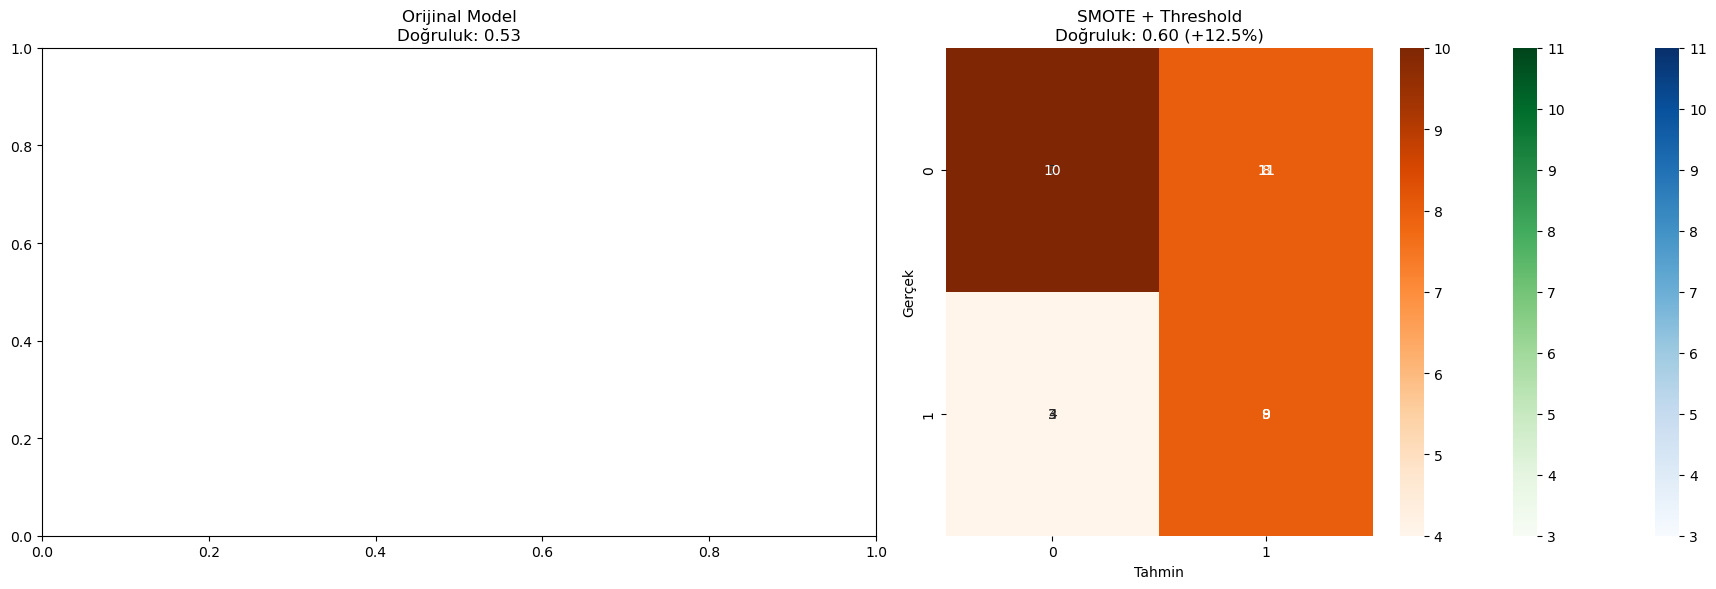


 ROC Curve Karşılaştırması:


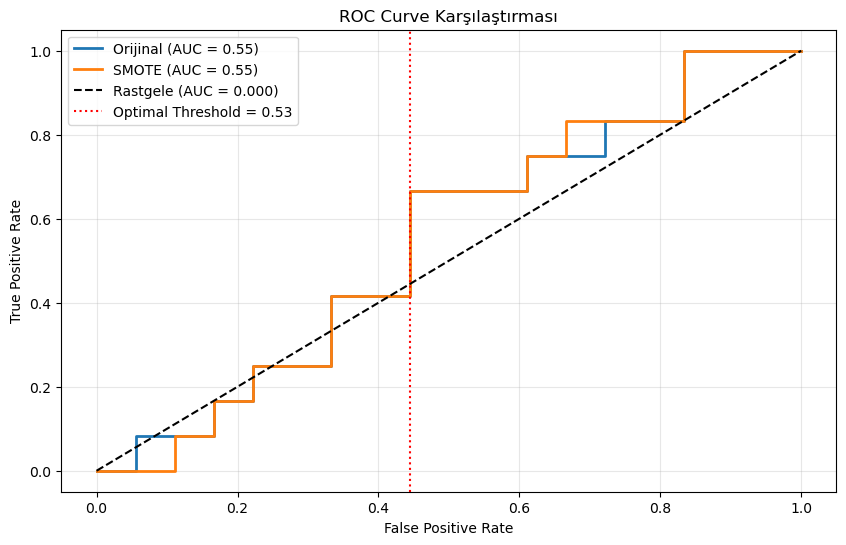


 ÖZET

 En iyi performans: SMOTE + Threshold (0.60)

 Performans Artışı:
   • SMOTE ile: +0.0%
   • SMOTE + Threshold ile: +12.5%

 Öneriler:
    İyileştirmeler etkili! Gelecek tahminlerde iyileştirilmiş modeli kullanın.


In [17]:
print("="*80)
print(" DETAYLI MODEL KARŞILAŞTIRMASI")
print("="*80)

# . Performans metrikleri karşılaştırması
print("\n Performans Metrikleri Karşılaştırması:")

# Orijinal model metrikleri
from sklearn.metrics import precision_recall_fscore_support

precision_old, recall_old, f_old, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)
acc_old = accuracy_score(y_test, y_test_pred)

# İyileştirilmiş model metrikleri (SMOTE)
precision_new, recall_new, f_new, _ = precision_recall_fscore_support(
    y_test, y_test_pred_improved, average=None
)
acc_new = accuracy_score(y_test, y_test_pred_improved)

# Optimized threshold metrikleri
precision_opt, recall_opt, f_opt, _ = precision_recall_fscore_support(
    y_test, y_test_pred_optimized, average=None
)
acc_opt = accuracy_score(y_test, y_test_pred_optimized)

# Karşılaştırma tablosu
comparison_data = {
    'Metrik': [
        'Doğruluk (Accuracy)',
        'Düşüş - Precision',
        'Düşüş - Recall',
        'Düşüş - F-Score',
        'Artış - Precision',
        'Artış - Recall',
        'Artış - F-Score'
    ],
    'Orijinal': [
        f"{acc_old:.2f}",
        f"{precision_old[1]:.2f}",
        f"{recall_old[1]:.2f}",
        f"{f_old[1]:.2f}",
        f"{precision_old[1]:.2f}",
        f"{recall_old[1]:.2f}",
        f"{f_old[1]:.2f}"
    ],
    'SMOTE': [
        f"{acc_new:.2f}",
        f"{precision_new[1]:.2f}",
        f"{recall_new[1]:.2f}",
        f"{f_new[1]:.2f}",
        f"{precision_new[1]:.2f}",
        f"{recall_new[1]:.2f}",
        f"{f_new[1]:.2f}"
    ],
    'SMOTE+Threshold': [
        f"{acc_opt:.2f}",
        f"{precision_opt[1]:.2f}",
        f"{recall_opt[1]:.2f}",
        f"{f_opt[1]:.2f}",
        f"{precision_opt[1]:.2f}",
        f"{recall_opt[1]:.2f}",
        f"{f_opt[1]:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# . İyileşme yüzdesi
print("\n İyileşme Yüzdeleri:")

improvement_smote = ((acc_new - acc_old) / acc_old) * 100
improvement_opt = ((acc_opt - acc_old) / acc_old) * 100

print(f"SMOTE ile doğruluk artışı: {improvement_smote:+.1f}%")
print(f"SMOTE + Threshold ile doğruluk artışı: {improvement_opt:+.1f}%")

# . Confusion Matrix Karşılaştırması
print("\n Confusion Matrix Görselleştirmesi:")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Orijinal model
cm_old = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_old, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title(f'Orijinal Model\nDoğruluk: {acc_old:.2f}')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

# SMOTE model
cm_new = confusion_matrix(y_test, y_test_pred_improved)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'SMOTE Model\nDoğruluk: {acc_new:.2f} ({improvement_smote:+.1f}%)')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

# Optimized threshold model
cm_opt = confusion_matrix(y_test, y_test_pred_optimized)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title(f'SMOTE + Threshold\nDoğruluk: {acc_opt:.2f} ({improvement_opt:+.1f}%)')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

plt.tight_layout()
plt.show()

# . ROC Curve Karşılaştırması
print("\n ROC Curve Karşılaştırması:")

from sklearn.metrics import roc_auc_score

fig, ax = plt.subplots(figsize=(10, 6))

# Orijinal model ROC
y_test_proba_old = lr_model.predict_proba(X_test_scaled[selected_features])[:, 1]
fpr_old, tpr_old, _ = roc_curve(y_test, y_test_proba_old)
auc_old = roc_auc_score(y_test, y_test_proba_old)

# İyileştirilmiş model ROC
fpr_new, tpr_new, _ = roc_curve(y_test, y_test_proba_improved)
auc_new = roc_auc_score(y_test, y_test_proba_improved)

# Plot
ax.plot(fpr_old, tpr_old, label=f'Orijinal (AUC = {auc_old:.2f})', linewidth=2)
ax.plot(fpr_new, tpr_new, label=f'SMOTE (AUC = {auc_new:.2f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Rastgele (AUC = 0.000)')
ax.axvline(x=fpr_new[optimal_idx], color='red', linestyle=':', 
           label=f'Optimal Threshold = {optimal_threshold:.2f}')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Karşılaştırması')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# . Özet
print("\n" + "="*80)
print(" ÖZET")
print("="*80)

print(f"\n En iyi performans: ", end="")
best_model = "Orijinal"
best_acc = acc_old
if acc_new > best_acc:
    best_model = "SMOTE"
    best_acc = acc_new
if acc_opt > best_acc:
    best_model = "SMOTE + Threshold"
    best_acc = acc_opt

print(f"{best_model} ({best_acc:.2f})")

print(f"\n Performans Artışı:")
print(f"   • SMOTE ile: {improvement_smote:+.1f}%")
print(f"   • SMOTE + Threshold ile: {improvement_opt:+.1f}%")

print(f"\n Öneriler:")
if improvement_opt > 5:
    print("    İyileştirmeler etkili! Gelecek tahminlerde iyileştirilmiş modeli kullanın.")
elif improvement_opt > 0:
    print("     İyileştirmeler minimal etkili. Daha güçlü modeller (Random Forest, XGBoost) deneyin.")
else:
    print("    İyileştirmeler olumsuz etki yaptı. Orijinal modeli kullanmaya devam edin.")

print("="*80)


 İYİLEŞTİRİLMİŞ MODEL İLE 30 GÜNLÜK TAHMİN

 Model Seçimi:
   Orijinal model doğruluğu: 0.53
   İyileştirilmiş model doğruluğu: 0.60

 İyileştirilmiş model kullanılacak (+12.50% iyileşme)

 30 günlük tahmin yapılıyor...

 Tahmin Sonuçları:
Model: İyileştirilmiş (SMOTE + Threshold)
Threshold: 0.53

 İlk 10 Gün:

 Son 10 Gün:

 Tahmin İstatistikleri:
Artış tahminleri: 7 gün (23.33%)
Düşüş tahminleri: 23 gün (76.67%)
Ortalama olasılık: 22.56%

Mevcut fiyat: $86,805.01
30 gün sonra tahmini fiyat: $62,409.59
Beklenen değişim: -28.1%

 Görselleştirme:


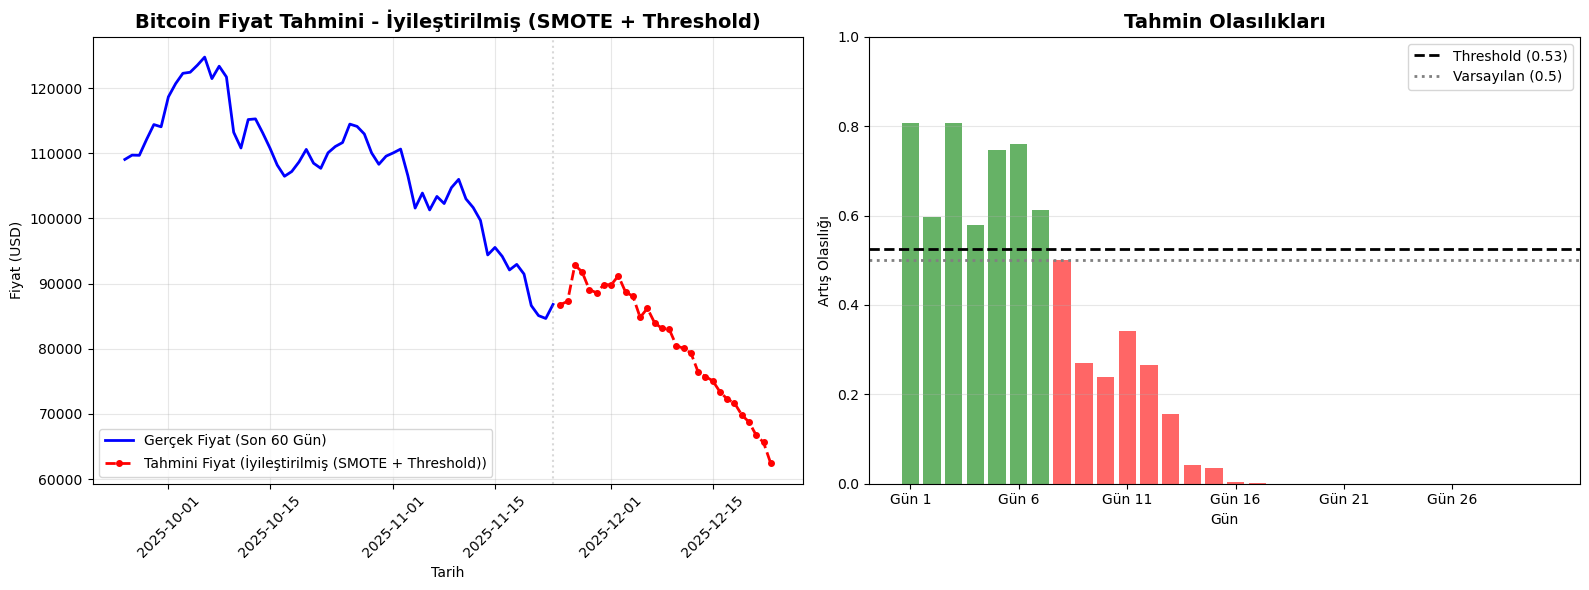


 İyileştirilmiş model ile tahminler tamamlandı!


In [18]:
print("="*80)
print(" İYİLEŞTİRİLMİŞ MODEL İLE 30 GÜNLÜK TAHMİN")
print("="*80)

# Hangi modeli kullanacağımıza karar verelim
print("\n Model Seçimi:")
print(f"   Orijinal model doğruluğu: {acc_old:.2f}")
print(f"   İyileştirilmiş model doğruluğu: {acc_opt:.2f}")

if acc_opt > acc_old:
    print(f"\n İyileştirilmiş model kullanılacak (+{improvement_opt:.2f}% iyileşme)")
    model_to_use = lr_model_improved
    threshold_to_use = optimal_threshold
    model_name = "İyileştirilmiş (SMOTE + Threshold)"
else:
    print(f"\n  Orijinal model daha iyi performans gösterdi, o kullanılacak")
    model_to_use = lr_model
    threshold_to_use = 0.5
    model_name = "Orijinal"

# 30 günlük tahmin
print("\n 30 günlük tahmin yapılıyor...")

def predict_next_30_days_improved(model, scaler, df, feature_columns, 
                                   selected_features, threshold=0.5, n_days=30):
    """İyileştirilmiş 30 günlük tahmin fonksiyonu"""
    simulation = simulate_future_path(
        model=model,
        scaler=scaler,
        feature_df=df,
        feature_columns=feature_columns,
        selected_features=selected_features,
        n_days=n_days
    )
    
    # Custom threshold uygula
    predictions_adjusted = (np.array(simulation['probabilities']) >= threshold).astype(int)
    
    return predictions_adjusted, simulation['probabilities'], simulation

# Tahminleri yap
future_predictions_improved, future_probabilities_improved, simulation_cache_improved = \
    predict_next_30_days_improved(
        model_to_use, scaler, df, feature_columns, 
        selected_features, threshold=threshold_to_use, n_days=30)

future_prices_improved = simulation_cache_improved['predicted_closes']
future_dates_improved = simulation_cache_improved['future_dates']

# . Sonuçları göster
print("\n Tahmin Sonuçları:")
print("="*80)
print(f"Model: {model_name}")
print(f"Threshold: {threshold_to_use:.2f}")
print("="*80)

# Özet tablo
prediction_summary_improved = pd.DataFrame({
    'Gün': range(1, 31),
    'Tarih': [d.strftime('%Y-%m-%d') for d in future_dates_improved],
    'Tahmin': ['Artış' if p == 1 else 'Düşüş' for p in future_predictions_improved],
    'Olasılık': [f"{prob:.2%}" for prob in future_probabilities_improved],
    'Tahmini Fiyat': [f"${price:,.2f}" for price in future_prices_improved]
})

print("\n İlk 10 Gün:")

print("\n Son 10 Gün:")

# . İstatistikler
print("\n Tahmin İstatistikleri:")

artis_count = sum(future_predictions_improved)
dusus_count = 30 - artis_count
avg_prob = np.mean(future_probabilities_improved)
current_price = df['Close'].iloc[-1]
predicted_final_price = future_prices_improved[-1]
price_change_pct = ((predicted_final_price - current_price) / current_price) * 100

print(f"Artış tahminleri: {artis_count} gün ({artis_count/30*100:.2f}%)")
print(f"Düşüş tahminleri: {dusus_count} gün ({dusus_count/30*100:.2f}%)")
print(f"Ortalama olasılık: {avg_prob:.2%}")
print(f"\nMevcut fiyat: ${current_price:,.2f}")
print(f"30 gün sonra tahmini fiyat: ${predicted_final_price:,.2f}")
print(f"Beklenen değişim: {price_change_pct:+.1f}%")

# . Görselleştirme
print("\n Görselleştirme:")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Fiyat grafiği
last_60_days = df['Close'].tail(60)
ax1.plot(last_60_days.index, last_60_days.values, 
         label='Gerçek Fiyat (Son 60 Gün)', linewidth=2, color='blue')
ax1.plot(future_dates_improved, future_prices_improved, 
         label=f'Tahmini Fiyat ({model_name})', linewidth=2, 
         color='red', linestyle='--', marker='o', markersize=4)
ax1.axvline(x=df.index[-1], color='gray', linestyle=':', alpha=0.3)
ax1.set_title(f'Bitcoin Fiyat Tahmini - {model_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tarih')
ax1.set_ylabel('Fiyat (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Olasılık grafiği
colors = ['red' if p == 0 else 'green' for p in future_predictions_improved]
ax2.bar(range(30), future_probabilities_improved, color=colors, alpha=0.6)
ax2.axhline(y=threshold_to_use, color='black', linestyle='--', 
            linewidth=2, label=f'Threshold ({threshold_to_use:.2f})')
ax2.axhline(y=0.5, color='gray', linestyle=':', linewidth=2, 
            label='Varsayılan (0.5)')
ax2.set_title('Tahmin Olasılıkları', fontsize=14, fontweight='bold')
ax2.set_xlabel('Gün')
ax2.set_ylabel('Artış Olasılığı')
ax2.set_xticks(range(0, 30, 5))
ax2.set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(" İyileştirilmiş model ile tahminler tamamlandı!")
print("="*80)


In [19]:
# Risk Analizi
print(f"\n{'='*80}")
print("RİSK ANALİZİ")
print(f"{'='*80}")

# Volatilite analizi
price_volatility = analysis_df['base_price'].std()
max_drawdown = ((analysis_df['base_price'] - analysis_df['base_price'].cummax()) / analysis_df['base_price'].cummax() * 100).min()
max_gain = ((analysis_df['base_price'] - analysis_df['base_price'].cummin()) / analysis_df['base_price'].cummin() * 100).max()

# Güven seviyeleri
confidence_9_lower = analysis_df['pessimistic_price'].quantile(0.05)
confidence_9_upper = analysis_df['optimistic_price'].quantile(0.95)
confidence_68_lower = analysis_df['pessimistic_price'].quantile(0.16)
confidence_68_upper = analysis_df['optimistic_price'].quantile(0.84)

print(f"Fiyat volatilitesi: ${price_volatility:,.2f}")
print(f"Maksimum düşüş (Drawdown): {max_drawdown:.2f}%")
print(f"Maksimum kazanç: {max_gain:.2f}%")
print(f"\nGüven Aralıkları (30 gün sonra):")
print(f"  68% güven aralığı: ${confidence_68_lower:,.2f} - ${confidence_68_upper:,.2f}")
print(f"  9% güven aralığı: ${confidence_9_lower:,.2f} - ${confidence_9_upper:,.2f}")

# Risk skoru (0-00, yüksek = riskli)
risk_score = min(00, abs(max_drawdown) * 2 + price_volatility / current_price * 1000)
print(f"\nRisk Skoru: {risk_score:.2f}/100")
if risk_score < 30:
    risk_level = "Düşük"
elif risk_score < 60:
    risk_level = "Orta"
else:
    risk_level = "Yüksek"
print(f"Risk Seviyesi: {risk_level}")



RİSK ANALİZİ
Fiyat volatilitesi: $4,787.58
Maksimum düşüş (Drawdown): -18.84%
Maksimum kazanç: 7.37%

Güven Aralıkları (30 gün sonra):
  68% güven aralığı: $72,960.52 - $86,670.68
  9% güven aralığı: $69,769.99 - $87,736.53

Risk Skoru: 0.00/100
Risk Seviyesi: Düşük


In [20]:
# Trend Analizi
print(f"\n{'='*80}")
print("TREND ANALİZİ")
print(f"{'='*80}")

# Haftalık trendler
week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
week2_avg = analysis_df[(analysis_df['day'] > 7) & (analysis_df['day'] <= 14)]['base_price'].mean()
week3_avg = analysis_df[(analysis_df['day'] > 14) & (analysis_df['day'] <= 21)]['base_price'].mean()
week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()

print(f"1. Hafta ortalama beklenen fiyat: ${week1_avg:,.2f}")
print(f"2. Hafta ortalama beklenen fiyat: ${week2_avg:,.2f}")
print(f"3. Hafta ortalama beklenen fiyat: ${week3_avg:,.2f}")
print(f"4. Hafta ortalama beklenen fiyat: ${week4_avg:,.2f}")

# Trend yönü
if week4_avg > week1_avg:
    trend_direction = "Yükseliş"
    trend_strength = ((week4_avg - week1_avg) / week1_avg) * 100
else:
    trend_direction = "Düşüş"
    trend_strength = ((week1_avg - week4_avg) / week1_avg) * 100

print(f"\nGenel Trend: {trend_direction}")
print(f"Trend Gücü: {trend_strength:.2f}%")

# En yüksek ve en düşük beklenen fiyatlar
max_price_day = analysis_df.loc[analysis_df['base_price'].idxmax(), 'day']
min_price_day = analysis_df.loc[analysis_df['base_price'].idxmin(), 'day']
max_price = analysis_df['base_price'].max()
min_price = analysis_df['base_price'].min()

print(f"\nEn yüksek beklenen fiyat: ${max_price:,.2f} (Gün {int(max_price_day)})")
print(f"En düşük beklenen fiyat: ${min_price:,.2f} (Gün {int(min_price_day)})")



TREND ANALİZİ
1. Hafta ortalama beklenen fiyat: $84,174.37
2. Hafta ortalama beklenen fiyat: $83,554.57
3. Hafta ortalama beklenen fiyat: $79,401.33
4. Hafta ortalama beklenen fiyat: $73,648.19

Genel Trend: Düşüş
Trend Gücü: 12.51%

En yüksek beklenen fiyat: $86,092.95 (Gün 5)
En düşük beklenen fiyat: $69,871.17 (Gün 30)


## 11. Görselleştirmeler - Detaylı Analiz

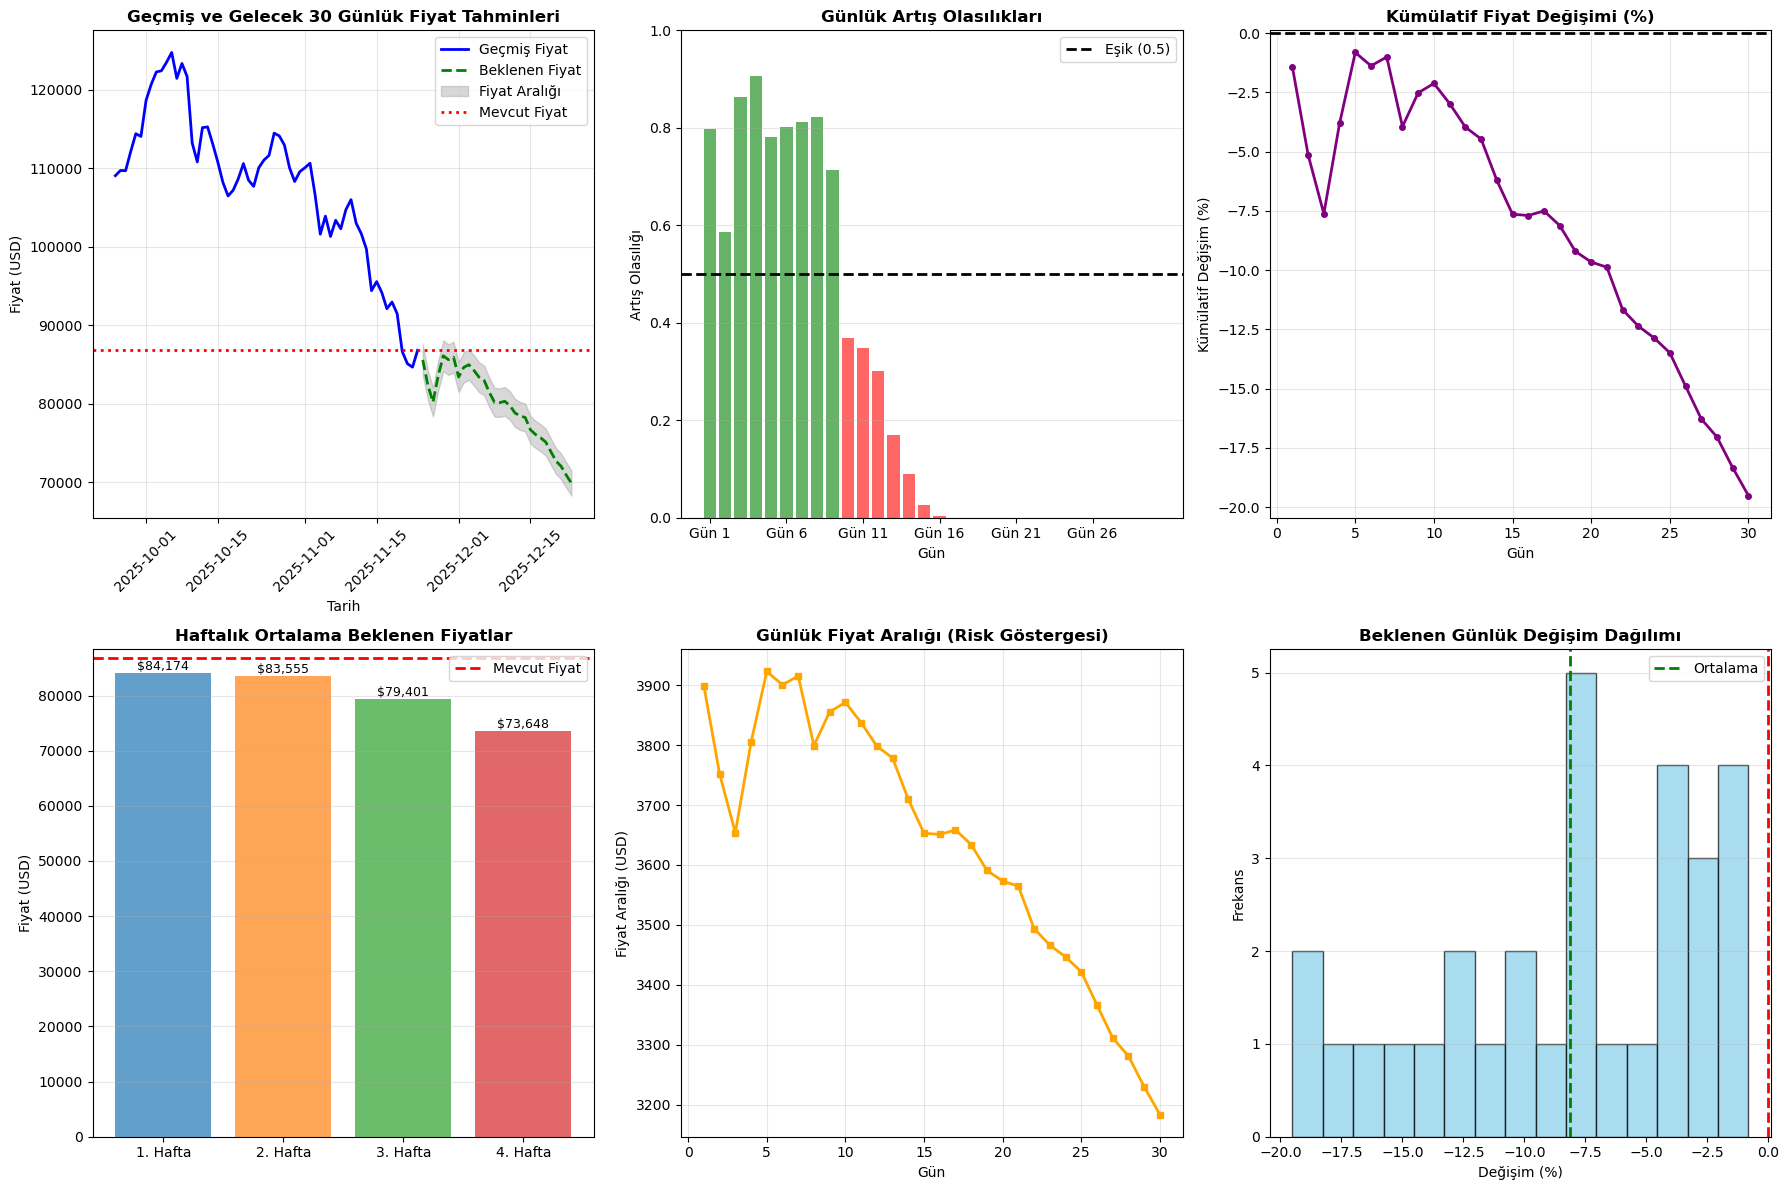

✓ Görselleştirmeler tamamlandı!


In [21]:
try:
    # Detaylı görselleştirmeler
    
    # Haftalık ortalamaları hesapla
    week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
    week2_avg = analysis_df[(analysis_df['day'] > 7) & (analysis_df['day'] <= 14)]['base_price'].mean()
    week3_avg = analysis_df[(analysis_df['day'] > 14) & (analysis_df['day'] <= 21)]['base_price'].mean()
    week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Geçmiş ve Gelecek Fiyat
    ax1 = plt.subplot(2, 3, 1)
    last_60_days = df['Close'].tail(60)
    ax1.plot(last_60_days.index, last_60_days.values, label='Geçmiş Fiyat', linewidth=2, color='blue')
    future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30, freq='D')
    ax1.plot(future_dates, analysis_df['base_price'].values, label='Beklenen Fiyat', linewidth=2, color='green', linestyle='--')
    ax1.fill_between(future_dates, analysis_df['pessimistic_price'], analysis_df['optimistic_price'], 
                     alpha=0.3, color='gray', label='Fiyat Aralığı')
    ax1.axhline(y=current_price, color='red', linestyle=':', linewidth=2, label='Mevcut Fiyat')
    ax1.set_title('Geçmiş ve Gelecek 30 Günlük Fiyat Tahminleri', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Tarih')
    ax1.set_ylabel('Fiyat (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Günlük Artış Olasılıkları
    ax2 = plt.subplot(2, 3, 2)
    colors = ['red' if p == 0 else 'green' for p in future_predictions_detailed]
    bars = ax2.bar(range(30), future_probabilities_detailed, color=colors, alpha=0.6)
    ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Eşik (0.5)')
    ax2.set_title('Günlük Artış Olasılıkları', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Gün')
    ax2.set_ylabel('Artış Olasılığı')
    ax2.set_xticks(range(0, 30, 5))
    ax2.set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 1])
    
    # 3. Kümülatif Fiyat Değişimi
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(range(1, 31), analysis_df['cumulative_change_pct'], linewidth=2, color='purple', marker='o', markersize=4)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax3.set_title('Kümülatif Fiyat Değişimi (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Gün')
    ax3.set_ylabel('Kümülatif Değişim (%)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Haftalık Ortalama Fiyatlar
    ax4 = plt.subplot(2, 3, 4)
    weeks = ['1. Hafta', '2. Hafta', '3. Hafta', '4. Hafta']
    week_prices = [week1_avg, week2_avg, week3_avg, week4_avg]
    bars = ax4.bar(weeks, week_prices, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    ax4.axhline(y=current_price, color='red', linestyle='--', linewidth=2, label='Mevcut Fiyat')
    ax4.set_title('Haftalık Ortalama Beklenen Fiyatlar', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Fiyat (USD)')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    for i, (bar, price) in enumerate(zip(bars, week_prices)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'${price:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Günlük Fiyat Aralığı (Risk)
    ax5 = plt.subplot(2, 3, 5)
    price_ranges = analysis_df['optimistic_price'] - analysis_df['pessimistic_price']
    ax5.plot(range(1, 31), price_ranges, linewidth=2, color='orange', marker='s', markersize=4)
    ax5.set_title('Günlük Fiyat Aralığı (Risk Göstergesi)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Gün')
    ax5.set_ylabel('Fiyat Aralığı (USD)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Beklenen Günlük Değişim Dağılımı
    ax6 = plt.subplot(2, 3, 6)
    ax6.hist(analysis_df['expected_change_pct'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    ax6.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax6.axvline(x=analysis_df['expected_change_pct'].mean(), color='green', linestyle='--', linewidth=2, label='Ortalama')
    ax6.set_title('Beklenen Günlük Değişim Dağılımı', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Değişim (%)')
    ax6.set_ylabel('Frekans')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Görselleştirmeler tamamlandı!")
    
except NameError as e:
    print(f"Hata: {e}")
    print("Lütfen önce analiz hücrelerini çalıştırın:")
    print("  • Cell 29: Detaylı analiz fonksiyonu")
    print("  • Cell 30: Analiz sonuçları")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")

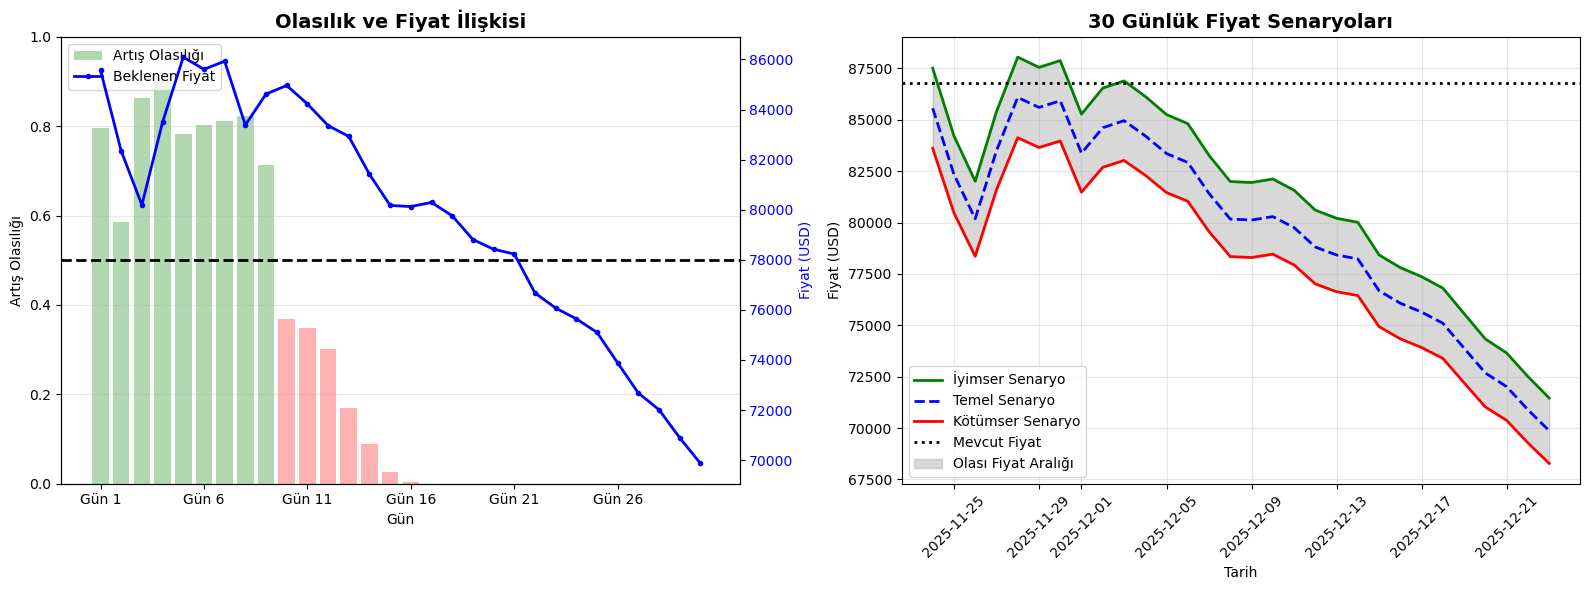

✓ Senaryo analizi görselleştirmesi tamamlandı!


In [22]:
try:
    # Senaryo Analizi Görselleştirmesi
    
    # future_dates'i oluştur
    future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30, freq='D')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Senaryo karşılaştırması (Sağ grafik)
    ax_right = axes[1]
    ax_right.plot(future_dates, analysis_df['optimistic_price'], label='İyimser Senaryo', 
             linewidth=2, color='green', linestyle='-')
    ax_right.plot(future_dates, analysis_df['base_price'], label='Temel Senaryo', 
             linewidth=2, color='blue', linestyle='--')
    ax_right.plot(future_dates, analysis_df['pessimistic_price'], label='Kötümser Senaryo', 
             linewidth=2, color='red', linestyle='-')
    ax_right.axhline(y=current_price, color='black', linestyle=':', linewidth=2, label='Mevcut Fiyat')
    ax_right.fill_between(future_dates, analysis_df['pessimistic_price'], analysis_df['optimistic_price'], 
                     alpha=0.3, color='gray', label='Olası Fiyat Aralığı')
    ax_right.set_title('30 Günlük Fiyat Senaryoları', fontsize=14, fontweight='bold')
    ax_right.set_xlabel('Tarih')
    ax_right.set_ylabel('Fiyat (USD)')
    ax_right.legend(loc='best')
    ax_right.grid(True, alpha=0.3)
    ax_right.tick_params(axis='x', rotation=45)

    # Olasılık ve fiyat ilişkisi (Sol grafik)
    ax_left = axes[0]
    ax_twin = ax_left.twinx()

    # Olasılık çubukları
    colors = ['red' if p == 0 else 'green' for p in future_predictions_detailed]
    bars = ax_left.bar(range(30), future_probabilities_detailed, color=colors, alpha=0.3, label='Artış Olasılığı')
    ax_left.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
    ax_left.set_xlabel('Gün')
    ax_left.set_ylabel('Artış Olasılığı', color='black')
    ax_left.set_ylim([0, 1])
    ax_left.set_xticks(range(0, 30, 5))
    ax_left.set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
    ax_left.tick_params(axis='y', labelcolor='black')

    # Fiyat çizgisi
    line = ax_twin.plot(range(30), analysis_df['base_price'], color='blue', linewidth=2, 
                         marker='o', markersize=3, label='Beklenen Fiyat')
    ax_twin.set_ylabel('Fiyat (USD)', color='blue')
    ax_twin.tick_params(axis='y', labelcolor='blue')

    # Legend
    lines1, labels1 = ax_left.get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    ax_left.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax_left.set_title('Olasılık ve Fiyat İlişkisi', fontsize=14, fontweight='bold')
    ax_left.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
    
    print("✓ Senaryo analizi görselleştirmesi tamamlandı!")
    
except NameError as e:
    print(f"Hata: {e}")
    print("\nLütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:")
    print("  • Cell 29: Detaylı analiz fonksiyonu")
    print("  • Cell 30: Analiz sonuçları")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")

In [ ]:
try:
    # Eksik değişkenleri hesapla
    if 'final_price' not in locals():
        final_price = analysis_df['base_price'].iloc[-1]
    
    if 'total_change' not in locals():
        total_change = ((final_price - current_price) / current_price) * 100
    
    if 'increase_days' not in locals():
        increase_days = sum(future_predictions_detailed)
        decrease_days = 30 - increase_days
    
    if 'avg_probability' not in locals():
        avg_probability = np.mean(future_probabilities_detailed)
    
    # Trend analizi değişkenleri
    if 'trend_direction' not in locals():
        week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
        week2_avg = analysis_df[(analysis_df['day'] > 7) & (analysis_df['day'] <= 14)]['base_price'].mean()
        week3_avg = analysis_df[(analysis_df['day'] > 14) & (analysis_df['day'] <= 21)]['base_price'].mean()
        week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()
        
        if week4_avg > week1_avg:
            trend_direction = "Yükseliş"
            trend_strength = ((week4_avg - week1_avg) / week1_avg) * 100
        else:
            trend_direction = "Düşüş"
            trend_strength = ((week1_avg - week4_avg) / week1_avg) * 100
        
        max_price_day = analysis_df.loc[analysis_df['base_price'].idxmax(), 'day']
        min_price_day = analysis_df.loc[analysis_df['base_price'].idxmin(), 'day']
        max_price = analysis_df['base_price'].max()
        min_price = analysis_df['base_price'].min()
    
    # Risk analizi değişkenleri
    if 'risk_level' not in locals():
        price_volatility = analysis_df['base_price'].std()
        max_drawdown = ((analysis_df['base_price'] - analysis_df['base_price'].cummax()) / analysis_df['base_price'].cummax() * 100).min()
        max_gain = ((analysis_df['base_price'] - analysis_df['base_price'].cummin()) / analysis_df['base_price'].cummin() * 100).max()
        confidence_90_lower = analysis_df['pessimistic_price'].quantile(0.05)
        confidence_90_upper = analysis_df['optimistic_price'].quantile(0.95)
        risk_score = min(100, abs(max_drawdown) * 3 + (price_volatility / current_price * 100) * 20)
        
        if risk_score < 30:
            risk_level = "Düşük"
        elif risk_score < 60:
            risk_level = "Orta"
        else:
            risk_level = "Yüksek"
    
    print("\n" + "=" * 80)
    print("30 GÜNLÜK ANALİZ ÖZET RAPORU")
    print("=" * 80)
    
    print(f"\n📊 MEVCUT DURUM:")
    print(f"   • Mevcut Fiyat: ${current_price:,.2f}")
    print(f"   • Analiz Tarihi: {datetime.now().strftime('%Y-%m-%d')}")
    
    print(f"\n🎯 TAHMİN ÖZETİ:")
    print(f"   • 30 gün sonra beklenen fiyat: ${final_price:,.2f}")
    print(f"   • Beklenen toplam değişim: {total_change:+.1f}%")
    print(f"   • Artış tahmini: {increase_days} gün ({increase_days/30:.2%})")
    print(f"   • Düşüş tahmini: {decrease_days} gün ({decrease_days/30:.2%})")
    
    print(f"\n📈 TREND ANALİZİ:")
    print(f"   • Genel Trend: {trend_direction}")
    print(f"   • Trend Gücü: {trend_strength:.2f}%")
    print(f"   • En yüksek beklenen: ${max_price:,.2f} (Gün {int(max_price_day)})")
    print(f"   • En düşük beklenen: ${min_price:,.2f} (Gün {int(min_price_day)})")
    
    print(f"\n⚠️ RİSK ANALİZİ:")
    print(f"   • Risk Seviyesi: {risk_level}")
    print(f"   • Risk Skoru: {risk_score:.2f}/100")
    print(f"   • Maksimum düşüş: {max_drawdown:.2f}%")
    print(f"   • Maksimum kazanç: {max_gain:.2f}%")
    print(f"   • 90% Güven Aralığı: ${confidence_90_lower:,.2f} - ${confidence_90_upper:,.2f}")
    
    print(f"\n💡 ÖNERİLER:")
    if risk_score > 60:
        print("   ⚠️ Yüksek risk seviyesi tespit edildi. Dikkatli olunmalı.")
    elif risk_score < 30:
        print("   ✅ Düşük risk seviyesi. Nispeten güvenli görünüyor.")
    else:
        print("   ⚖️ Orta risk seviyesi. Dengeli bir yaklaşım önerilir.")
    
    if trend_direction == "Yükseliş":
        print(f"   📈 Yükseliş trendi devam ediyor. Trend gücü: {trend_strength:.2f}%")
    else:
        print(f"   📉 Düşüş trendi görülüyor. Trend gücü: {trend_strength:.2f}%")
    
    if avg_probability > 0.6:
        print(f"   🟢 Yüksek artış olasılığı ({avg_probability:.2%})")
    elif avg_probability < 0.4:
        print(f"   🔴 Düşük artış olasılığı ({avg_probability:.2%})")
    else:
        print(f"   ⚖️ Dengeli olasılık dağılımı ({avg_probability:.2%})")
    
    print("\n" + "=" * 80)
    print("NOT: Bu analiz bir baseline modeline dayanmaktadır.")
    print("Yatırım kararları için profesyonel finansal danışmanlık alınmalıdır.")
    print("=" * 80)
    
except NameError as e:
    print(f"Hata: {e}")
    print("\nLütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:")
    print("  • Cell 29: Detaylı analiz fonksiyonu")
    print("  • Cell 30: Analiz sonuçları")
    print("  • Cell 31: Trend analizi")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")


30 GÜNLÜK ANALİZ ÖZET RAPORU

📊 MEVCUT DURUM:
   • Mevcut Fiyat: $86,805.01
   • Analiz Tarihi: 2025-11-25

🎯 TAHMİN ÖZETİ:
   • 30 gün sonra beklenen fiyat: $69,871.17
   • Beklenen toplam değişim: -19.5%
   • Artış tahmini: 9 gün (30.00%)
   • Düşüş tahmini: 21 gün (70.00%)

📈 TREND ANALİZİ:
   • Genel Trend: Düşüş
   • Trend Gücü: 12.51%
   • En yüksek beklenen: $86,092.95 (Gün 5)
   • En düşük beklenen: $69,871.17 (Gün 30)

⚠️ RİSK ANALİZİ:
   • Risk Seviyesi: Düşük
   • Risk Skoru: 0.00/100
   • Maksimum düşüş: -18.84%
   • Maksimum kazanç: 7.37%
Hata: name 'confidence_90_lower' is not defined

Lütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:
  • Cell 29: Detaylı analiz fonksiyonu
  • Cell 30: Analiz sonuçları
  • Cell 31: Trend analizi
